### General Utilities

In [1]:
import numpy as np
import pandas as pd
import os
import datetime
from pathlib import Path
import janitor

### Data Visualization

In [121]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

from matplotlib_inline.backend_inline import flush_figures

plt.rcParams['figure.figsize'] = [12, 8]

### Data Preprocessing

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

### Model Training and Evaluation

In [4]:
# Classical Models
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Machine Learning Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Gradient Boosting Models
import xgboost as xgb
from xgboost import plot_importance
import lightgbm as lgb
#import catboost as cb

In [131]:
# Time-Series Specific
import stumpy  # For time series similarity and matrix profiles
#import darts  # Unified time series modeling library
#from darts.models import ExponentialSmoothing, RNNModel, ARIMA, Prophet

# Feature Engineering
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

In [6]:
# load in processed data
df = pd.read_csv('../data/processed/final_df.csv', parse_dates=['ds'])

In [7]:
df_clean = df.clean_names() # clean column names for consistency

In [9]:
# Select relevant columns for analysis
daily_cols = ['ndic_file_no', 'api_no', 'well_type', 'well_status',
       'latitude','longitude', 'current_operator', 'current_well_name', 'total_depth',
       'field', 'perfs', 'filenumber','well_id','ds', 'producing_days', 'y', 'daily_gas_rate',
       'daily_water_rate', 'cumulative_oil_bbls', 'cumulative_gas_mcf',
       'cumulative_wtr_bbls', 'rolling_oil_mean', 'rolling_oil_std',
       'is_outlier', 'trend', 'yhat', 'yhat_lower', 'yhat_upper']
daily_df = df_clean[daily_cols]

In [10]:
# Filter for wells with status 'A' (active wells)
daily_df = daily_df.query(
    "well_status == 'A'"
)

# Rename column 'y' to 'daily_oil_rate' for clarity
daily_df = daily_df.rename(columns={'y':'daily_oil_rate'})
# Fill missing rolling oil mean values with daily oil rate
daily_df['rolling_oil_mean'] = daily_df['rolling_oil_mean'].fillna(daily_df['daily_oil_rate'])

In [11]:
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42842 entries, 1 to 46303
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ndic_file_no         42842 non-null  int64         
 1   api_no               42842 non-null  object        
 2   well_type            42842 non-null  object        
 3   well_status          42842 non-null  object        
 4   latitude             42842 non-null  float64       
 5   longitude            42842 non-null  float64       
 6   current_operator     42842 non-null  object        
 7   current_well_name    42842 non-null  object        
 8   total_depth          42842 non-null  float64       
 9   field                42842 non-null  object        
 10  perfs                42019 non-null  object        
 11  filenumber           42842 non-null  int64         
 12  well_id              42840 non-null  float64       
 13  ds                   42840 non-null 

In [68]:
# let's start with ARIMA just to get a general baseline 
import warnings

# Suppress specific warning
warnings.filterwarnings("ignore", message="A date index has been provided, but it has no associated frequency information")
warnings.filterwarnings("ignore", message="No supported index is available. Prediction results will be given with an integer index beginning at `start`.")
warnings.filterwarnings("ignore", message="No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception")
# only need target and date columns

arima_df = daily_df[['ds','current_well_name','daily_oil_rate']]

# Ensure the data is sorted by date and well
arima_df = arima_df.sort_values(['current_well_name','ds'])
# loop through each well and fit ARIMA
arima_well_models = {}

for well, group in arima_df.groupby('current_well_name'):    
    # Set date to index
    group = group.set_index('ds')
    # Remove rows where 'daily_oil_rate' is NaN
    group = group.dropna(subset=['daily_oil_rate'])
    
    if group['daily_oil_rate'].notnull().sum() > 0:
        try:            
            target_series = group['daily_oil_rate'].dropna()           
            # Fit ARIMA (choose appropriate parameters or use auto_arima)
            print(f"Fitting ARIMA for Well: {well}")
            model = ARIMA(target_series, order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False) 
            fitted_model = model.fit()
            forecast = fitted_model.forecast(steps=12)    
            
            # Save the model
            arima_well_models[well] = [fitted_model.fittedvalues,forecast]
            
        except RuntimeError as e:
            print(f'error {e} fitting well {well}')
    else:
        print(f"{well} has no valid data after handling missing values. Skipping.")

Fitting ARIMA for Well: AMUNDSON 23-14H
Fitting ARIMA for Well: ANDERSON  11-13H
Fitting ARIMA for Well: ANDERSON 13-24-1TFH
Fitting ARIMA for Well: ANDERSON 13-24-2TFH
Fitting ARIMA for Well: ANDERSON 13-24-3TFH
Fitting ARIMA for Well: ANDERSON 13-24-4TFH
Fitting ARIMA for Well: ANDERSON STATE 43-30H
Fitting ARIMA for Well: ANDREW SCHMIDT 1-3-10H-143-97
Fitting ARIMA for Well: ANKENBAUER 160-90-34-P-1H
Fitting ARIMA for Well: BAKKE  11-24H
Fitting ARIMA for Well: BEATRICE KUBISCHTA 1-15-22H-143-96
Fitting ARIMA for Well: BEATRICE KUBISCHTA 2-15-22H-143-96
Fitting ARIMA for Well: BEATRICE KUBISCHTA 3-15-22H-143-96
Fitting ARIMA for Well: BEHR 16-21 2H-LL-155-91
Fitting ARIMA for Well: BEHR 16-21H


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:881: RuntimeWarning: invalid value encountered in subtract
  endog - np.mean(endog)]
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS wi

Fitting ARIMA for Well: BIG SPRING 1-22-27H-160-90
Fitting ARIMA for Well: BISMARCK STATE 34-27-28H
Fitting ARIMA for Well: BOB  16-21H
Fitting ARIMA for Well: BREW  2-13-12H-143-96
Fitting ARIMA for Well: BREW 1-13-12H-143-96
Fitting ARIMA for Well: BREW 3-13-12H-143-96
Fitting ARIMA for Well: BREW 4-13-12H-143-96
Fitting ARIMA for Well: BULLINGER TRUST 1-18-19H-142-96


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda

Fitting ARIMA for Well: Behr 16-21 1TFH-LL-155-91
Fitting ARIMA for Well: Brew 5-13-12H-143-96L
CABERNET SWD 1 has no valid data after handling missing values. Skipping.
Fitting ARIMA for Well: CARISSA 27-34H
Fitting ARIMA for Well: CAROL 43-29H
Fitting ARIMA for Well: CGB 30-31H
Fitting ARIMA for Well: CHICO 28-33-1TFH
Fitting ARIMA for Well: CJ 27-34H
Fitting ARIMA for Well: CLIFFORD  14-24H-25
Fitting ARIMA for Well: CORPRON 16-21-22H
Fitting ARIMA for Well: CRAFT 21-16H


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda

Fitting ARIMA for Well: CRAFT 22-15H
Fitting ARIMA for Well: CRAFT 27-34H
Fitting ARIMA for Well: CRAFT 44-29H
Fitting ARIMA for Well: CURLY 29-32-1TFH
Fitting ARIMA for Well: DAKOTA MEYER 2-19-18H-143-97
Fitting ARIMA for Well: DARLENE DVORAK 1-27-34H-143-95
Fitting ARIMA for Well: DAVID KOVASH 1-12-13H-142-96
Fitting ARIMA for Well: DAVID SADOWSKY 1-11-14H-142-96


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Fitting ARIMA for Well: DELVIN DUKART 1-31-30H-143-95
Fitting ARIMA for Well: DELVIN DUKART 2-31-30H-143-95
Fitting ARIMA for Well: DELVIN DUKART 6-30-31H-143-95
Fitting ARIMA for Well: DENNIS KADRMAS 1-9-4H-143-96
Fitting ARIMA for Well: DENNIS KADRMAS 2-9-4H-143-96
Fitting ARIMA for Well: DENNIS KADRMAS 3-9-4H-143-96
Fitting ARIMA for Well: DIMOND SWD 1


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda

Fitting ARIMA for Well: DUSTY 29-32-1TFH
Fitting ARIMA for Well: DVORAK STATE 1-16-21H-142-96
Fitting ARIMA for Well: DYLAN 22-15H
Fitting ARIMA for Well: EASY STREET 3-4H
Fitting ARIMA for Well: EDITH  14-29H-32
Fitting ARIMA for Well: EDWARD POLENSKY 1-13-24H-142-97
Fitting ARIMA for Well: EKLUND 159-90-4-P-1H
Fitting ARIMA for Well: ELEANOR TWIST  1-3-10H-143-95
Fitting ARIMA for Well: ELEANOR TWIST 2-3-10H-143-95
Fitting ARIMA for Well: ELEANOR TWIST 4-3-10H-143-95
Fitting ARIMA for Well: ELROY KADRMAS 1-10-3H-143-96
Fitting ARIMA for Well: ELROY KADRMAS 2-10-3H-143-96
Fitting ARIMA for Well: ELROY KADRMAS 3-10-3H-143-96
Fitting ARIMA for Well: ELROY KADRMAS 4-3-10H-143-96
Fitting ARIMA for Well: ELROY KADRMAS 5-3-10H-143-96
Fitting ARIMA for Well: ELROY KADRMAS 6-3-10H-143-96
Fitting ARIMA for Well: EMERSON 1-24-25H-143-96


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda

Fitting ARIMA for Well: EMERSON 2-24-25H-143-96
Fitting ARIMA for Well: EMERSON 3-24-25H-143-96
Fitting ARIMA for Well: EMIL 14-13H-24
Fitting ARIMA for Well: EMIL VEVERKA  5-20-17H-143-95L
Fitting ARIMA for Well: EMIL VEVERKA 3-17-20H-143-95
Fitting ARIMA for Well: EMIL VEVERKA 4-17-20H-143-95
Fitting ARIMA for Well: ENANDER 41-32H-29


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda

Fitting ARIMA for Well: ENGER 1-15-22H-142-97
Fitting ARIMA for Well: ERICKSON 160-91-8-D-1H
Fitting ARIMA for Well: EVELYN KARY 1-15-22H-144-97
Fitting ARIMA for Well: EVELYN KARY 2-22-15H-144-97
Fitting ARIMA for Well: EVELYN KARY 3-22-15H-144-97
Fitting ARIMA for Well: EVELYN KARY 4-22-15H-144-97
Fitting ARIMA for Well: EVELYN STROH 1-17-20H-143-96


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda

Fitting ARIMA for Well: EVELYN STROH 2-17-20H-143-96
Fitting ARIMA for Well: EVELYN STROH 3-17-20H-143-96
Fitting ARIMA for Well: Eleanor Twist 3-3-10H 143-95
Fitting ARIMA for Well: Emerson 4-24-25H-143-96
Fitting ARIMA for Well: Emerson 5-24-25H-143-96L
Fitting ARIMA for Well: FEAST OF FOOLS 12-16H
Fitting ARIMA for Well: FEDERAL ADELBERT AMES 1-19-18H-143-94
Fitting ARIMA for Well: FEDERAL BUD  1-32-29H-143-96
Fitting ARIMA for Well: FEDERAL BUD 2-32-29H-143-96


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda

Fitting ARIMA for Well: FEDERAL BUD 3-29-32H-143-96
Fitting ARIMA for Well: FEDERAL BUD 4-29-32H-143-96
Fitting ARIMA for Well: FEDERAL KUBIK TRUST 1-19-18H-143-95
Fitting ARIMA for Well: FEDERAL KUBIK TRUST 2-18-19H-143-95
Fitting ARIMA for Well: FEDERAL KUBIK TRUST 4-19-18H-143-95
Fitting ARIMA for Well: FEDERAL STAAEL 2-32-5H-160-90L
Fitting ARIMA for Well: FEDERAL STEFFAN 1-7-6H-142-96
Fitting ARIMA for Well: FEDERAL TORMASCHY  1-8-5H-142-96


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.


Fitting ARIMA for Well: FEDERAL TORMASCHY  2-5-8H-142-96
Fitting ARIMA for Well: FEDERAL TRIPPELL 32-16H
Fitting ARIMA for Well: FRANCHUK 44-5H
Fitting ARIMA for Well: Federal Kubik Trust 3-18-19H-143-95L
Fitting ARIMA for Well: GARFIELD 30-31H
Fitting ARIMA for Well: GRESZ STATE 14-36H
Fitting ARIMA for Well: GRIGGS 2-8-9H-142-97
Fitting ARIMA for Well: GYPSEY 6 16-21H
Fitting ARIMA for Well: H REID TTT 33-28H
Fitting ARIMA for Well: HANK 28-33H
Fitting ARIMA for Well: HANSEN  18-19-1H RD
Fitting ARIMA for Well: HANSEN 18-19-2H
Fitting ARIMA for Well: HANSEN B 18-19-1H
Fitting ARIMA for Well: HANSEN B 18-19-2TFH
Fitting ARIMA for Well: HANSEN B 18-19-4TFHL
Fitting ARIMA for Well: HARLAN REBSOM 1-2-11H-143-95X
Fitting ARIMA for Well: HAROLDSON 160-91-14-D-1H
Fitting ARIMA for Well: HARRY STROH 1-8-5H-143-96


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda

Fitting ARIMA for Well: HARRY STROH 2-8-5H-143-96
Fitting ARIMA for Well: HARRY STROH 3-8-5H-143-96
Fitting ARIMA for Well: HARSTAD   44-9H
Fitting ARIMA for Well: HARSTAD 18-19H
Fitting ARIMA for Well: HARSTAD 44-9-2H
Fitting ARIMA for Well: HARSTAD 9-1TFH-155-91


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Us

Fitting ARIMA for Well: HEISER TRUST 11-3H
Fitting ARIMA for Well: HENRY KOVASH 1-6-7H-142-95
Fitting ARIMA for Well: HENRY KOVASH 3-7-6H-142-95
Fitting ARIMA for Well: HENRY KOVASH 5-6-7H-142-95
Fitting ARIMA for Well: HIGH RIDGE 8-5-1H-160-90
Fitting ARIMA for Well: HILL  31-30H
Fitting ARIMA for Well: HONKERS 9-16H
Fitting ARIMA for Well: Hansen B 18-19-3TFH


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda

ICEMAN SWD #1 has no valid data after handling missing values. Skipping.
Fitting ARIMA for Well: IRENE 12-13H-24
Fitting ARIMA for Well: JACOBSON 160-90-6-P-1H
Fitting ARIMA for Well: JACOBSON 8-33H
Fitting ARIMA for Well: JAEGER STATE 1-34-27H-144-97
Fitting ARIMA for Well: JAEGER STATE 2-34-26H-144-97L
Fitting ARIMA for Well: JAKE MCNIECE 1-34-27H-143-97
Fitting ARIMA for Well: JERRY 15-22H
Fitting ARIMA for Well: JOE V SEMERAD 1-12-1H-142-97
Fitting ARIMA for Well: JON R  16-21-22H
Fitting ARIMA for Well: Jon R 16-21 2TFH
Fitting ARIMA for Well: Jon R 16-21-1TFH
Fitting ARIMA for Well: Jon R 16-22-3TFH
Fitting ARIMA for Well: KADRMAS 41-1H


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Us

Fitting ARIMA for Well: KANNEGIETER 160-90-17 P-1H
Fitting ARIMA for Well: KARY 1-24-13H-144-97
Fitting ARIMA for Well: KARY 3-24-13H-144-97
Fitting ARIMA for Well: KARY 4-24-13H-144-97
Fitting ARIMA for Well: KARY 7-24-13H-144-97L
Fitting ARIMA for Well: KARY STATE 34-19H
Fitting ARIMA for Well: KATHLEEN STROH 1-20-17H-143-95
Fitting ARIMA for Well: KENNETH STROH  3-12-1H-143-97


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda

Fitting ARIMA for Well: KENNETH STROH  5-1H-143-97
Fitting ARIMA for Well: KENNETH STROH 1-12-1H-143-97
Fitting ARIMA for Well: KENNETH STROH 2-12-1H-143-97
Fitting ARIMA for Well: KENNETH STROH 4-12-1H-143-97
Fitting ARIMA for Well: KENNETH STROH 6-12-1H-143-97L
Fitting ARIMA for Well: KEVIN  24-9H
Fitting ARIMA for Well: KRABLES 22-15H
Fitting ARIMA for Well: LAMEY 1-30-31H-143-96
Fitting ARIMA for Well: LAMEY 2-30-31H-143-96
Fitting ARIMA for Well: LAMEY 3-30-31H-143-96L
Fitting ARIMA for Well: LAMEY 4-30-31H-143-96
Fitting ARIMA for Well: LARRY 29-32-1TFHL
Fitting ARIMA for Well: LAURA SADOWSKY 1-1-36H-142-96
Fitting ARIMA for Well: LAURA SADOWSKY 2-1-36H-142-96
Fitting ARIMA for Well: LAURA SADOWSKY 3-1-36H-142-96
Fitting ARIMA for Well: LEISS  4-26-23H-143-96
Fitting ARIMA for Well: LEISS 1-23-26H-143-96
Fitting ARIMA for Well: LEISS 2-23-26H-143-96
Fitting ARIMA for Well: LEISS 3-23-26H-143-96


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Fitting ARIMA for Well: LEROY PETRY 1-20-17H-143-97
Fitting ARIMA for Well: LILLIAN SADOWSKY 1-15-22H-142-96
Fitting ARIMA for Well: LITTLE BUTTE 1-21-28H-160-90
Fitting ARIMA for Well: LITTLE BUTTE 2-28-21H-160-90
Fitting ARIMA for Well: LORI 18-19H
Fitting ARIMA for Well: LOUIS SADOWSKY 1-10-3H-142-96
Fitting ARIMA for Well: LUCKY 30-31-1TFHL
Fitting ARIMA for Well: MAD HATTER 16-4H
MANNING SWD 1 has no valid data after handling missing values. Skipping.
Fitting ARIMA for Well: MARTIN  4-30-31H-144-96


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda

Fitting ARIMA for Well: MARTIN  6-31-30H-144-96
Fitting ARIMA for Well: MARTIN 2-30-31H-144-96
Fitting ARIMA for Well: MARTIN 5-30-31H-144-96
Fitting ARIMA for Well: MASTERS ENTERPRISES 1
Fitting ARIMA for Well: MATTHEW SCHMIDT  2-35-2H-144-97
Fitting ARIMA for Well: MATTHEW SCHMIDT  3-35-2H-144-97
Fitting ARIMA for Well: MATTHEW SCHMIDT  4-2-35H-143-97
Fitting ARIMA for Well: MATTHEW SCHMIDT 1-35-2H-143-97


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.


Fitting ARIMA for Well: MILDRED SADOWSKY  1-11-14H-142-97
Fitting ARIMA for Well: MILDRED SADOWSKY  2-11-14H-142-97
Fitting ARIMA for Well: MILDRED SADOWSKY  3-11-14H-142-97
Fitting ARIMA for Well: MILLER 44-31H
Fitting ARIMA for Well: MINOT STATE 34-33-28H
Fitting ARIMA for Well: MOE 29-32-1TFH
Fitting ARIMA for Well: MOEN 23-14H
Fitting ARIMA for Well: MOGREN 159-90-5-P-1H
Fitting ARIMA for Well: MOOSE DROOL 9-16H


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda

Fitting ARIMA for Well: MYHRA 28-33H
Fitting ARIMA for Well: NEAL 1-33-28H-144-95
Fitting ARIMA for Well: NEAL 2-33-28H-144-95
Fitting ARIMA for Well: NEAL 3-33-28H-144-95
Fitting ARIMA for Well: NEAL 4-33-28H-144-95
Fitting ARIMA for Well: NEAL 5-33-28H-144-95L
Fitting ARIMA for Well: NELSON 1-12-1H-143-95
Fitting ARIMA for Well: NESSON 31-30H
Fitting ARIMA for Well: NORDLOEF 160-90-30P-1H


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Us

Fitting ARIMA for Well: NORDLOEF 4-30-19TFH-160-90L
Fitting ARIMA for Well: OXY 160-91-10-4-P-2H
Fitting ARIMA for Well: OXY SWENSON 160-91-13-11-P-2H
Fitting ARIMA for Well: PICK AXE 19-4H
Fitting ARIMA for Well: RAPHAEL STROH 1-13-24H-143-97
Fitting ARIMA for Well: RAPHAEL STROH 2-13-24H-143-97
Fitting ARIMA for Well: RAPHAEL STROH 3-13-24H-143-97


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Us

Fitting ARIMA for Well: RAPHAEL STROH 4-13-24H-143-97
Fitting ARIMA for Well: RAPHAEL STROH 5-13-24H-143-97L
Fitting ARIMA for Well: REBSOM 1-23-14H-143-95
Fitting ARIMA for Well: REBSOM 3-14-23H-143-95
Fitting ARIMA for Well: REBSOM 4-14-23H-143-95
Fitting ARIMA for Well: REBSOM 5-14-23H-143-95
Fitting ARIMA for Well: RED LADY 36-4H
Fitting ARIMA for Well: REPETOWSKI 1-34-27H-143-98


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda

Fitting ARIMA for Well: REUBEN SCHNEIDER 1-27-34H-143-96
Fitting ARIMA for Well: REUM 11-32 SWD
Fitting ARIMA for Well: REUM 31-30H
Fitting ARIMA for Well: RICHARD DVORAK 1-33-28H-143-95
Fitting ARIMA for Well: ROBERT SADOWSKY  2-35-2H-143-96
Fitting ARIMA for Well: ROBERT SADOWSKY 1-2-35H-142-96
Fitting ARIMA for Well: ROGSTAD 14-23H


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Fitting ARIMA for Well: RONALD 11-32H
Fitting ARIMA for Well: SANDY 18-19-2H
Fitting ARIMA for Well: SANDY 18-19-3TFH
Fitting ARIMA for Well: SCHNEIDER 11-33-28H-143-96
Fitting ARIMA for Well: SCHNEIDER 12-34-27H-143-96L
Fitting ARIMA for Well: SCHNEIDER 2-28-33H-143-96
Fitting ARIMA for Well: SCOTT  2-7-6H-143-95
Fitting ARIMA for Well: SCOTT 3-7-6H-143-95
Fitting ARIMA for Well: SCOTT 34-7H


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda

Fitting ARIMA for Well: SCOTT 4-7-6H -143-95L
Fitting ARIMA for Well: SHARON RAINEY 1-17-20H-142-96
Fitting ARIMA for Well: SHARON RAINEY 3-17-20H-142-96
Fitting ARIMA for Well: SHARON RAINEY 5-17-20H-142-96L
Fitting ARIMA for Well: SHIRLEY ANNE 34-9H
Fitting ARIMA for Well: SHUCK 2-33-28H-144-97
Fitting ARIMA for Well: SHUCK 3-33-28H-144-97
Fitting ARIMA for Well: SHUCK 5-28-33H-144-97
Fitting ARIMA for Well: SHUCK 6-33-28H-144-97
Fitting ARIMA for Well: SHUCK 7-33-28H-144-97
Fitting ARIMA for Well: SORLIE  160-90-7-P16-1H


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda

Fitting ARIMA for Well: SORLIE 160-90-18-P-1H
Fitting ARIMA for Well: SPLIT RIDGE 1-2-1H-160-91
Fitting ARIMA for Well: STAAEL 160-90-33-D-1H
Fitting ARIMA for Well: STAG 1-35-23H-142-96
Fitting ARIMA for Well: STATE  34-33-28H
Fitting ARIMA for Well: STATE  4-21-16H-143-96
Fitting ARIMA for Well: STATE 1-16-21H-143-96
Fitting ARIMA for Well: STATE 1-25-36H-144-97X
Fitting ARIMA for Well: STATE 1-36-25H-143-97
Fitting ARIMA for Well: STATE 11-32H
Fitting ARIMA for Well: STATE 2-16-21H-143-96
Fitting ARIMA for Well: STATE 2-25-36H-144-97
Fitting ARIMA for Well: STATE 3-16-21H-143-96
Fitting ARIMA for Well: STATE 30-31H
Fitting ARIMA for Well: STATE 5-25-36H-144-97
Fitting ARIMA for Well: STATE 6-25-36H-144-97
Fitting ARIMA for Well: STATE 7-25-36H-144-97L
Fitting ARIMA for Well: STATE ANDREW SCHMIDT 2-3-10H-143-97
Fitting ARIMA for Well: STATE ANDREW SCHMIDT 3-3-10H-143-97
Fitting ARIMA for Well: STATE B 3-25-36H-143-97
Fitting ARIMA for Well: STATE BRIAN SADOWSKY 1-10-3H-142-97
Fitting

C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda

Fitting ARIMA for Well: STATE BUFFALO BILL 1-20-17H-143-94
Fitting ARIMA for Well: STATE CALLY 1-26-23H-142-97
Fitting ARIMA for Well: STATE DUKART 1-24-13H-143-95
Fitting ARIMA for Well: STATE DVORAK A  2-16-21H-142-96
Fitting ARIMA for Well: STATE DVORAK A 4-16-21H-142-96
Fitting ARIMA for Well: STATE GRESZ 1-35-26H-143-98
STATE GRESZ 2 SWD has no valid data after handling missing values. Skipping.
Fitting ARIMA for Well: STATE GRESZ 3-26-35H-143-98
Fitting ARIMA for Well: STATE GRESZ 5-26-35H-143-98
Fitting ARIMA for Well: STATE GRESZ 6-35-26H-143-98
Fitting ARIMA for Well: STATE HECKER  1-2-11H-142-98
Fitting ARIMA for Well: STATE JAEGER B 4-27-34H-144-97
Fitting ARIMA for Well: STATE JAEGER B 5-27-34H-144-97
Fitting ARIMA for Well: STATE JAEGER B 6-27-34H-144-97
Fitting ARIMA for Well: STATE JAEGER B 7-27-34H-144-97
Fitting ARIMA for Well: STATE KARY  5-19-18H-144-96
Fitting ARIMA for Well: STATE KARY 2-19-18H-144-96


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda

Fitting ARIMA for Well: STATE KARY 3-19-18H-144-96
Fitting ARIMA for Well: STATE KARY 4-19-18H-144-96
Fitting ARIMA for Well: STATE KNOPIK 1-21-16H-144-97
Fitting ARIMA for Well: STATE KNOPIK 2-21-16H-144-97
Fitting ARIMA for Well: STATE KNOPIK 3-21-16H-144-97
Fitting ARIMA for Well: STATE RUCK 1-21-16H-143-97
Fitting ARIMA for Well: STATE TUHY 1-25-36H-143-95
Fitting ARIMA for Well: STATE WATKINS  1-26-35H-143-95


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda

Fitting ARIMA for Well: STEFFAN  2-29-28H-143-97
Fitting ARIMA for Well: SUNDTS 23-14-15H
Fitting ARIMA for Well: SUNSHINE 31-16H
Fitting ARIMA for Well: SWENSON 160-91-11-P-1H
Fitting ARIMA for Well: SWENSON 160-91-15-D-1H
Fitting ARIMA for Well: SWENSON 160-91-4-P-1H
Fitting ARIMA for Well: State B 2-25-36H-143-97
Fitting ARIMA for Well: TONY KRALICEK 1-5-8H-142-95
Fitting ARIMA for Well: TRUE BLONDE  16-15H
Fitting ARIMA for Well: TTT RANCH 33-28H
Fitting ARIMA for Well: TTT RANCH 34-27XH


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda

Fitting ARIMA for Well: TWIST 2-4-9H-143-95
Fitting ARIMA for Well: TWIST 3-4-9H-143-95
Fitting ARIMA for Well: TWIST 31-4H
Fitting ARIMA for Well: TWIST 4-4-9H-143-95
Fitting ARIMA for Well: TWIST 5-3-10H-143-95L
Fitting ARIMA for Well: VELENCHENKO 1-4-9H-143-97
Fitting ARIMA for Well: VELENCHENKO 2-4-9H-143-97
Fitting ARIMA for Well: VELENCHENKO 3-4-9H-143-97
Fitting ARIMA for Well: WANNEMACHER 1-4-9H-142-95
Fitting ARIMA for Well: WARD HILL 2-29-20H-160-90
Fitting ARIMA for Well: WARD HILL 20-29-1H-160-90


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\alley\miniconda

Fitting ARIMA for Well: WARD LAKE 1-5-6H-160-91
Fitting ARIMA for Well: WILLIAM KUBISCHTA 1-14-11H-143-96
Fitting ARIMA for Well: WILLIAM KUBISCHTA 2-14-11H-143-96
Fitting ARIMA for Well: WILLIAM KUBISCHTA 3-14-11H-143-96
Fitting ARIMA for Well: WILLIAM KUBISCHTA 4-11-14H-143-96
Fitting ARIMA for Well: WILLIAM SADOWSKY 2-9-4H-142-96
Fitting ARIMA for Well: WILLIAM SADOWSKY 7-4-9H-142-96
Fitting ARIMA for Well: WILLIAM SADOWSKY 9-4-9H-142-96
Fitting ARIMA for Well: WITTINGER 2-8-5H-143-95
Fitting ARIMA for Well: WITTINGER 3-8-5H-143-95
Fitting ARIMA for Well: WITTINGER 31-5H
Fitting ARIMA for Well: WITTINGER 4-8-5H-143-95


C:\Users\alley\miniconda3\envs\oil_and_gas_production_workflow\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [116]:
def plot_arima_well(df,well):
    """
    Plot Prophet forecast with actual data and highlight outliers.

    Parameters:
    - forecast: The forecast dataframe from the model.
   
    """
    # Filter the data for the specific well_id
    # Extract fitted and forecasted values
    time = arima_well_models[well][0].index.values
    fitted_values = arima_well_models[well][0].values
    forecast_values = arima_well_models[well][1]    
    well_data = arima_df[arima_df['current_well_name'] == well].dropna()    
    
    # Plot the actual vs forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(time, well_data['daily_oil_rate'], label='Actual Daily Oil Rate', color='green', marker='o', linestyle='-')
    plt.plot(time, fitted_values, label='Arima Fit Daily Oil Rate', color='blue', linestyle='--')  
    # Extend the time index for the forecasted values
    last_date = time[-1]  # Last date in the fitted values
    # Add forecasted values
    forecast_time = pd.date_range(start=last_date, periods=len(forecast_values) + 1, freq='ME')[1:] 
    plt.plot(forecast_time, forecast_values.values, label='ARIMA Forecast Daily Oil Rate', color='red', linestyle='--')
    
    # Add titles and labels
    plt.title('Actual vs Forecasted Daily Oil Rate for Well 18406')
    plt.xlabel('Days')
    plt.ylabel('Daily Oil Rate')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()
    
    # Show the plot
    plt.show()

C:\Users\alley\AppData\Local\Temp\ipykernel_17424\3066981272.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_time = pd.date_range(start=last_date, periods=len(forecast_values) + 1, freq='M')[1:]


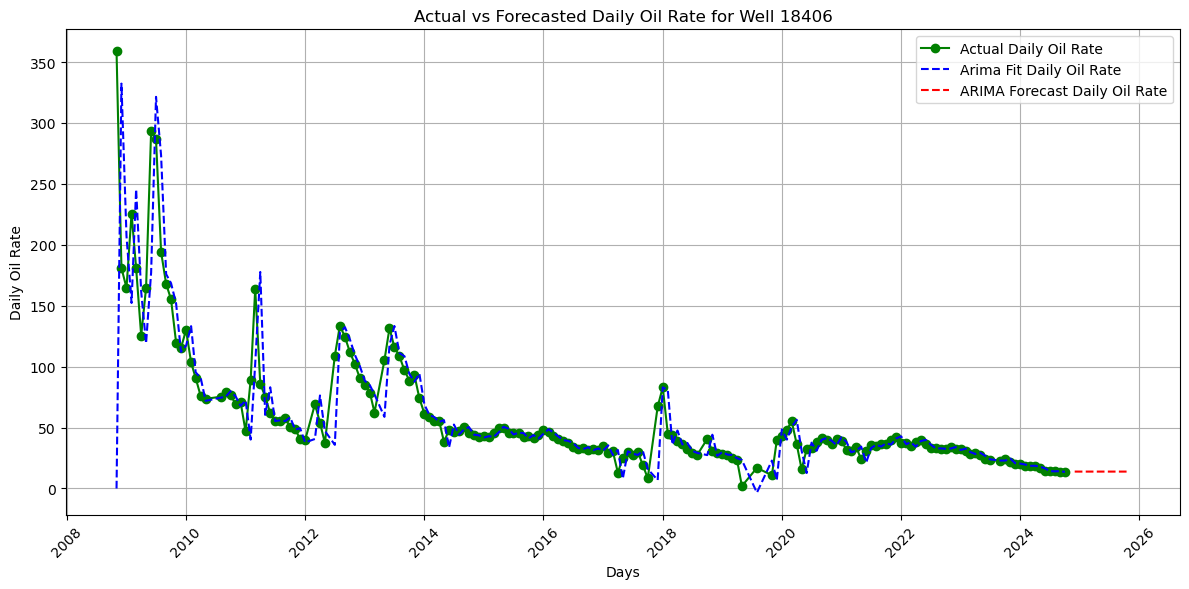

In [115]:
# Example usage:
pd.set_option('future.no_silent_downcasting', True)
well = 'BAKKE  11-24H' # Replace with the desired File Number

plot_arima_well(arima_df, well)

In [127]:
def wrapped_plot_arima_well(well):
    plot_arima_well(arima_df, well)
# Widgets
well_list =  sorted(arima_df['current_well_name'].unique())

# Create a dropdown for well selection
dropdown = widgets.Dropdown(options=well_list, description='Select Well:')

# Create an interactive widget
interactive_plot = widgets.interactive(wrapped_plot_arima_well, well=dropdown)


# Display the interactive plot
display(interactive_plot)


interactive(children=(Dropdown(description='Select Well:', options=('AMUNDSON 23-14H', 'ANDERSON  11-13H', 'AN…

## Commentary on ARIMA Model Performance

The ARIMA models applied to this dataset produce forecasts that are nearly flat (constant production rates) beyond the historical data. This behavior is likely due to the following reasons:

1. **Non-Stationary Data**:
   - Oil production data often exhibits non-stationary patterns, including trends, or abrupt declines over time. ARIMA models require the data to be stationary, and the flat forecasts suggest that these patterns were not fully accounted for in the preprocessing steps (e.g., insufficient differencing).
   - Maybe go back and fit on diff.

2. **Limited Parameter Tuning**:
   - The `(1,1,1)` parameterization of ARIMA was applied across all wells without extensive tuning. This one-size-fits-all approach may fail to capture the unique production behaviors of individual wells.

3. **ARIMA’s Inherent Limitations**:
   - ARIMA is fundamentally a linear model and may struggle to capture complex, non-linear behaviors or external influences such as operational changes, reservoir heterogeneity, or interventions that are common in oil and gas production.

### Next Steps
Given these challenges, it's worth exploring other models that might better capture the dynamic behavior of the data:

1. **Tree-Based Models**:
   - Models like Gradient Boosting Machines (GBMs), XGBoost, or LightGBM can leverage historical features and interactions, offering non-linear modeling capabilities.

2. **Time-Series Specific Models**:

   - **Stumpy**: A Python library designed for matrix profile computation, which can help identify patterns, motifs, and anomalies in time series data. Stumpy is well-suited for understanding recurring trends and identifying subsequences with similar behaviors.
   - **Prophet**: While not tree-based, Prophet by Facebook is a robust model for capturing seasonality and trend components in time-series data.
   - **Hybrid Models**: Combining traditional time-series methods with feature engineering for use in tree-based models could also yield better results.

### Conclusion
The current results underscore the limitations of ARIMA in this context, especially when dealing with complex, non-stationary oil production data. Transitioning to more advanced or tailored modeling approaches is likely to yield more actionable insights and robust forecasts.


In [143]:
ts_df = arima_df.copy()
# Generate lag features
for lag in range(1, 13):  # Lags for the last 12 months
    ts_df[f'lag_{lag}'] = ts_df.groupby('current_well_name')['daily_oil_rate'].shift(lag)

# Generate rolling aggregates
ts_df['rolling_mean_3'] = ts_df.groupby('current_well_name')['daily_oil_rate'].rolling(3).mean().reset_index(0, drop=True)
ts_df['rolling_std_3'] = ts_df.groupby('current_well_name')['daily_oil_rate'].rolling(3).std().reset_index(0, drop=True)
